In [ ]:
!pip install -Uq gpytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 4.9 MB/s eta 0:00:00


In [ ]:
import tqdm
import math
import torch
import numpy as np

import torch.distributions as dist

import gpytorch
import pandas as pd
from matplotlib import pyplot as plt

In [142]:
import math
from numbers import Number, Real

import torch
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import _standard_normal, broadcast_all


class CensoredNormal(ExponentialFamily):
    """
    Creates a censored normal (also called Gaussian) distribution parameterized by
    :attr:`loc` and :attr:`scale` and :attr:`low`  and :attr:`high`

    Example::

        >>> # xdoctest: +IGNORE_WANT("non-deterministic")
        >>> m = CensoredNormal(
          torch.tensor([0.0]), torch.tensor([1.0]),
          torch.tensor([-0.5]), torch.tensor([0.5])
          )
        >>> m.sample(sample_shape=(3,1))
        tensor([[0.5000],
            [0.5000],
            [0.1836]])
        tensor([ 0.1046])

    Args:
        loc (float or Tensor): mean of the base normal distribution (often referred to as mu) to which the censoring is applied
        scale (float or Tensor): standard deviation of the base normal distribution to which the censoring is applied
        low (float or Tensor): lower censoring boundary
        high (float or Tensor): upper censoring boundary
    """
    arg_constraints = {
        "loc": constraints.real,
        "scale": constraints.positive,
        "low": constraints.dependent(is_discrete=False, event_dim=0),
        "high": constraints.dependent(is_discrete=False, event_dim=0)}
    has_rsample = True
    _mean_carrier_measure = 0

    @property
    def mean(self):
        x_high = (self.high - self.loc)/self.scale
        cdf_high = self._normal_cdf(self.high)
        pdf_high = math.exp(self._normal_log_prob(self.high))
        x_low = (self.low - self.loc)/self.scale
        cdf_low = self._normal_cdf(self.low)
        pdf_low = math.exp(self._normal_log_prob(self.low))
        term1 = cdf_high - cdf_low
        term2 = pdf_high - pdf_low
        return self.loc * term1 - self.scale * term2

    @property
    def stddev(self):
        return self.variance.sqrt()

    @property
    def variance(self):
        x_high = (self.high - self.loc)/self.scale
        cdf_high = self._normal_cdf(self.high)
        pdf_high = math.exp(self._normal_log_prob(self.high))
        x_low = (self.low - self.loc)/self.scale
        cdf_low = self._normal_cdf(self.low)
        pdf_low = math.exp(self._normal_log_prob(self.low))
        term1 = cdf_high - cdf_low
        term2 = x_high * pdf_high - x_low * pdf_low
        return  (self.scale ** 2) * (term1 - term2)


    def __init__(self, loc, scale, low, high, validate_args=None):
        self.loc, self.scale, self.low, self.high = broadcast_all(loc, scale, low, high)
        if isinstance(loc, Number) and isinstance(scale, Number) and isinstance(low, Number) and isinstance(high, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.loc.size()
        support = constraints.interval(low, high)
        super().__init__(batch_shape, validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(CensoredNormal, _instance)
        batch_shape = torch.Size(batch_shape)
        new.loc = self.loc.expand(batch_shape)
        new.scale = self.scale.expand(batch_shape)
        new.low = self.low.expand(batch_shape)
        new.high = self.high.expand(batch_shape)
        super(CensoredNormal, new).__init__(batch_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new

    @constraints.dependent_property(is_discrete=False, event_dim=0)
    def support(self):
        return constraints.interval(self.low, self.high)


    def sample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        with torch.no_grad():
            samples = torch.normal(self.loc.expand(shape), self.scale.expand(shape))
            return samples.clamp(min=self.low, max=self.high)


    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        eps = _standard_normal(shape, dtype=self.loc.dtype, device=self.loc.device)
        rsamples =  self.loc + eps * self.scale
        return rsamples.clamp(min=self.low, max=self.high)

    def pdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        probs = torch.exp(self.log_prob(value))
        lower_cdf_mass = self._normal_cdf(self.low)
        upper_cdf_mass = 1 - self._normal_cdf(self.high)
        probs = torch.where(value <= self.low, lower_cdf_mass, probs)
        probs = torch.where(value >= self.high, upper_cdf_mass, probs)
        return probs

    def log_prob(self, value, jitter=1e-12):
        """jitter: used to bounce off NormCDF from 0 before applying log """
        if self._validate_args:
            self._validate_sample(value)
        log_probs = self._normal_log_prob(value)
        lower_log_cdf_mass = math.log(self._normal_cdf(self.low) + jitter) if isinstance(self._normal_cdf(self.low) + jitter,
                                                                                                Number) else (self._normal_cdf(self.low) + jitter).log()
        upper_log_cdf_mass = math.log(1 - self._normal_cdf(self.high) + jitter) if isinstance(1 - self._normal_cdf(self.high) + jitter,
                                                                                                    Number) else (1 - self._normal_cdf(self.high) + jitter).log()
        log_probs = torch.where(value <= self.low, lower_log_cdf_mass, log_probs)
        log_probs = torch.where(value >= self.high, upper_log_cdf_mass, log_probs)
        return log_probs

    def cdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        cdf_ = self._normal_cdf(value)
        cdf_ = torch.where(value < self.low, 0, cdf_)
        cdf_ = torch.where(value > self.high, 1, cdf_)
        return cdf_

    def icdf(self, value):
        result = self._normal_icdf(value)
        return result.clamp(min=self.low, max=self.high)

    def entropy(self, jitter=1e-12):
        x_low = (self.low - self.loc)/self.scale
        x_high = (self.high - self.loc)/self.scale

        logcdf_x_low = math.log(self._normal_cdf(self.low) + jitter) if isinstance(self._normal_cdf(self.low) + jitter,
                                                                                                  Number) else (self._normal_cdf(self.low) + jitter).log()
        logcdf_x_high = math.log(self._normal_cdf_standardized(-x_high) + jitter) if isinstance(self._normal_cdf_standardized(x_high) + jitter,
                                                                                                      Number) else (self._normal_cdf_standardized(-x_high) + jitter).log()

        term1 = self._normal_entropy() * (self._normal_cdf(self.high)- self._normal_cdf(self.low))
        term2 = 0.5 * (x_high * torch.exp(self._normal_log_prob(self.high)) - x_low * torch.exp(self._normal_log_prob(self.low)))
        term3 = logcdf_x_low * self._normal_cdf(self.low)
        term4 = logcdf_x_high * (self._normal_cdf_standardized(-x_high))
        return term1 - term2 - term3 - term4


    def _normal_log_prob(self, value):
            # compute the variance
            var = self.scale**2
            log_scale = (
                math.log(self.scale) if isinstance(self.scale, Real) else self.scale.log()
            )
            return (
                -((value - self.loc) ** 2) / (2 * var)
                - log_scale
                - math.log(math.sqrt(2 * math.pi))
            )

    def _normal_cdf(self, value):
        return 0.5 * (
            1 + torch.erf((value - self.loc) * self.scale.reciprocal() / math.sqrt(2))
        )

    def _normal_cdf_standardized(self, z):
        return 0.5 * (
            1 + torch.erf(z / math.sqrt(2))
        )

    def _normal_icdf(self, value):
        return self.loc + self.scale * torch.erfinv(2 * value - 1) * math.sqrt(2)


    def _normal_entropy(self):\
        # log(sqrt(2 pi e) * sigma) = 0.5 * log(2 pi e) + log(sigma) = 0.5 + 0.5 (log(2 pi)) + log(sigma)
        return 0.5 + 0.5 * math.log(2 * math.pi) + torch.log(self.scale)

    @property
    def _normal_natural_params(self):
        return (self.loc / self.scale.pow(2), -0.5 * self.scale.pow(2).reciprocal())

    def _log_normalizer(self, x, y):
        return -0.25 * x.pow(2) / y + 0.5 * torch.log(-math.pi / y)

In [253]:
import warnings
from typing import Any

import torch
from linear_operator.operators import LinearOperator, ZeroLinearOperator
from torch import Tensor
from torch.distributions import Distribution, Normal

from gpytorch.constraints import Interval
from gpytorch.distributions import base_distributions, MultivariateNormal
from gpytorch.priors import Prior
from gpytorch.utils.warnings import GPInputWarning
from gpytorch.likelihoods.likelihood import _Likelihood, _OneDimensionalLikelihood


class CensoredGaussianLikelihood(_Likelihood):
    """Base class for Censored Gaussian Likelihoods."""
    def __init__(self, variance=None, low=None, high=None) -> None:
        super().__init__()

        variance = torch.tensor(1.) if variance is None else variance
        self.noise = gpytorch.likelihoods.noise_models.HomoskedasticNoise()
        self.noise.initialize(noise=variance)
        self.low = low
        self.high = high

    @property
    def variance(self):
      return self.noise.noise

    def forward(self, function_samples: Tensor, *params: Any, **kwargs: Any):
        return CensoredNormal(function_samples, scale=self.variance.sqrt(), low=self.low, high=self.high)

class CensoredGaussianLikelihoodMathematica(CensoredGaussianLikelihood):
    def __init__(self, variance=None, low=None, high=None) -> None:
        super().__init__(variance, low, high)

    def expected_log_prob(self, target: Tensor, input: MultivariateNormal, *params: Any, **kwargs: Any) -> Tensor:
        noise = self.variance # likelihood
        mean, variance = input.mean, input.variance # approximate posterior

        jitter_=1e-16

        upper_censor = lambda x, s: (self.high - x) / s
        lower_censor = lambda x, s: (self.low - x) / s

        standard_normal = dist.Normal(0,1)
         # Gaussian term
        term1 = 2. + torch.log(noise) + math.log(2 * math.pi)
        term2 = ((target - mean).square() + variance) * noise.reciprocal()
        term3 = standard_normal.cdf(upper_censor(mean, variance.sqrt())) - standard_normal.cdf(lower_censor(mean, variance.sqrt()))
        normal_part_unscaled = (term1 - term2).mul(0.5)
        normal_part = normal_part_unscaled * term3

        # upper term
        x1 = (self.high - 2*target + mean) * variance.sqrt()
        term4 = torch.clamp_min(standard_normal.cdf(-upper_censor(target, variance.sqrt())), jitter_).log() + 0.5 * x1 * noise.reciprocal()
        upper_censored_part = term4 * standard_normal.log_prob(upper_censor(mean, variance.sqrt())).exp()

        # lower term
        x2 = (self.low - 2*target + mean) * variance.sqrt()
        term5 = torch.clamp_min(standard_normal.cdf(lower_censor(target, variance.sqrt())), jitter_).log() - 0.5 * x2 * noise.reciprocal()
        lower_censored_part = term5 * standard_normal.log_prob(lower_censor(mean, variance.sqrt())).exp()

        res = normal_part - lower_censored_part - upper_censored_part
        return res

class CensoredGaussianLikelihoodAnalytic(CensoredGaussianLikelihood):
    def __init__(self, variance=None, low=None, high=None, alpha=1., gamma=1., dzeta=1., jitter_=1e-16) -> None:
        super().__init__(variance, low, high)
        self.alpha = alpha
        self.gamma = gamma
        self.dzeta = dzeta
        self.jitter_ = jitter_

    def expected_log_prob(self, target: Tensor, input: MultivariateNormal, *params: Any, **kwargs: Any) -> Tensor:
        noise = self.variance # likelihood
        mean, variance = input.mean, input.variance # approximate posterior

        upper_censor = lambda x, s: (self.high - x) / s
        lower_censor = lambda x, s: (self.low - x) / s

        standard_normal = dist.Normal(0,1)
         # Gaussian term
        term1 = torch.log(noise) + math.log(2 * math.pi)
        term2 = ((target - mean).square() + variance) * noise.reciprocal()
        term3 = standard_normal.cdf(upper_censor(mean, variance.sqrt())) - standard_normal.cdf(lower_censor(mean, variance.sqrt()))
        normal_part_unscaled = (term1 - term2).mul(0.5)
        normal_part = normal_part_unscaled * term3

        # upper term
        x1 = (self.high - 2*target + mean) * variance.sqrt()
        term4 = torch.clamp_min(standard_normal.cdf(-upper_censor(target, variance.sqrt())), self.jitter_).log() + 0.5 * x1 * noise.reciprocal()
        upper_censored_part = term4 * standard_normal.log_prob(upper_censor(mean, variance.sqrt())).exp()

        # lower term
        x2 = (self.low - 2*target + mean) * variance.sqrt()
        term5 = torch.clamp_min(standard_normal.cdf(lower_censor(target, variance.sqrt())), self.jitter_).log() - 0.5 * x2 * noise.reciprocal()
        lower_censored_part = term5 * standard_normal.log_prob(lower_censor(mean, variance.sqrt())).exp()

        res = self.alpha * normal_part - self.gamma * upper_censored_part - self.dzeta * lower_censored_part
        return res

In [252]:
print('\nMathematica:')
print(torch.as_tensor([
    CensoredGaussianLikelihoodMathematica(variance=1,low=-1,high=1).expected_log_prob(
        y[None],
        MultivariateNormal(y[None], torch.diag(torch.ones(1)))
    )
    for y in torch.as_tensor([-1, -0.5, 0, 0.5, 1])
]).numpy(force=True).round(6))

print('\nAnalytic:')
print(torch.as_tensor([
    CensoredGaussianLikelihoodAnalytic(variance=1,low=-1,high=1).expected_log_prob(
        y[None],
        MultivariateNormal(y[None], torch.diag(torch.ones(1)))
    )
    for y in torch.as_tensor([-1, -0.5, 0, 0.5, 1])
]).numpy(force=True).round(6))

print('\nAnalytic - Mathematica:')
print(torch.as_tensor([
    CensoredGaussianLikelihoodAnalytic(variance=1,low=-1,high=1).expected_log_prob(
        y[None],
        MultivariateNormal(y[None], torch.diag(torch.ones(1)))
    )
    for y in torch.as_tensor([-1, -0.5, 0, 0.5, 1])
]).numpy(force=True).round(6) - np.array([1.103980, 1.465660, 1.617670, 1.465660, 1.103980]))


Mathematica:
[1.103981 1.465658 1.61767  1.465658 1.103981]

Analytic:
[0.626731 0.841003 0.934981 0.841003 0.626731]

Analytic - Mathematica:
[-0.47724902 -0.624657   -0.68268901 -0.624657   -0.47724902]


In [254]:
for y_i in torch.linspace(-1., 1., 10):
    print('y',y_i)
    lik_i = CensoredGaussianLikelihoodAnalytic(0.1,y_i,y_i+1)
    print('lik',(0.1,y_i,y_i+1))
    f_i = MultivariateNormal(y_i[None], torch.diag(torch.ones(1)))
    print('f',f_i)
    print(lik_i.expected_log_prob(y_i[None],f_i))
    print('='*40)

y tensor(-1.)
lik (0.1, tensor(-1.), tensor(0.))
f MultivariateNormal(loc: tensor([-1.]), covariance_matrix: tensor([[1.]]))
tensor([-2.2739], grad_fn=<SubBackward0>)
y tensor(-0.7778)
lik (0.1, tensor(-0.7778), tensor(0.2222))
f MultivariateNormal(loc: tensor([-0.7778]), covariance_matrix: tensor([[1.]]))
tensor([-2.2739], grad_fn=<SubBackward0>)
y tensor(-0.5556)
lik (0.1, tensor(-0.5556), tensor(0.4444))
f MultivariateNormal(loc: tensor([-0.5556]), covariance_matrix: tensor([[1.]]))
tensor([-2.2739], grad_fn=<SubBackward0>)
y tensor(-0.3333)
lik (0.1, tensor(-0.3333), tensor(0.6667))
f MultivariateNormal(loc: tensor([-0.3333]), covariance_matrix: tensor([[1.]]))
tensor([-2.2739], grad_fn=<SubBackward0>)
y tensor(-0.1111)
lik (0.1, tensor(-0.1111), tensor(0.8889))
f MultivariateNormal(loc: tensor([-0.1111]), covariance_matrix: tensor([[1.]]))
tensor([-2.2739], grad_fn=<SubBackward0>)
y tensor(0.1111)
lik (0.1, tensor(0.1111), tensor(1.1111))
f MultivariateNormal(loc: tensor([0.1111])

In [274]:
def rgetattr(o, k_list):
  for k in k_list:
    o = getattr(o,k)
  return o

def print_module(module):
  with torch.no_grad():
    for name, _ in module.named_parameters():
      name = name.replace('raw_','')
      param = rgetattr(module, name.split('.'))
      print(f'{name:35} {tuple(param.shape)}\n{param.numpy().round(10)}')

def get_module(module):
  ret = {}
  with torch.no_grad():
    for name, _ in module.named_parameters():
      name = name.replace('raw_','')
      param = rgetattr(module, name.split('.'))
      ret[name] = param.numpy()
  return ret

# Synthetic 1D

In [275]:
MAX_VALUE = 0.0

def noise_free_target(x):
    y = (x-2)*10
    return y * torch.sin(y) / 2

def oracle(x):
    return torch.clamp_max(noise_free_target(x) + torch.randn(x.shape) , 0.0)

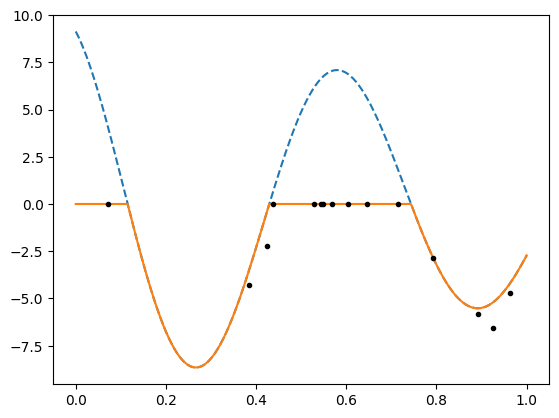

In [276]:
N_init = 15
np.random.seed(0)
x = torch.FloatTensor(np.random.rand(N_init))
torch.sort(x)
y = oracle(x)

domain = torch.linspace(0, 1, 500)
plt.plot(domain, noise_free_target(domain), '--');
plt.plot(domain, torch.clamp_max(noise_free_target(domain), 0), '-');
plt.plot(x, y, 'k.')

# ELBO Implementation

In [314]:
from gpytorch.models import ApproximateGP # handles basic variational inference
from gpytorch.variational import CholeskyVariationalDistribution # distribution of the approximation q(f)
from gpytorch.variational import VariationalStrategy # use when larger sample - transform q(u) to q(f) over inducing points

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        # defines approximation
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points,
                                                   variational_distribution, learn_inducing_locations=False)
        super(GPModel, self).__init__(variational_strategy)
        # defines the GP
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


model = GPModel(inducing_points=x[:,None])
likelihood = CensoredGaussianLikelihoodAnalytic(low=-100., high=MAX_VALUE, alpha=5., gamma=0., dzeta=0.)

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [261]:
# model.covar_module.base_kernel.initialize(lengthscale=0.5)
# model.covar_module.initialize(outputscale=5);
# model.mean_module.initialize(constant=0.1)
# likelihood.noise.initialize(noise=.5);

In [315]:
print_module(likelihood)
print_module(model)

noise.noise                         (1,)
[1.]
variational_strategy._variational_distribution.variational_mean (15,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
variational_strategy._variational_distribution.chol_variational_covar (15, 15)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
mean_module.constant                (

In [316]:
num_epochs = 5_000
pbar = tqdm.tqdm(range(num_epochs), position=0, leave=True)

model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.001)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y.size(0))

params_log = dict()
for iter in pbar:
    optimizer.zero_grad();
    y_pred = model(x[:,None])
    loss = -mll(y_pred, y)
    loss.backward()
    optimizer.step()
    params_log[iter] = {
        'loss': loss.item(),
        'outscale': model.covar_module.outputscale.item(),
        'mean_module': model.mean_module.constant.item(),
        'noise': likelihood.noise.noise.item()
        }

    if iter%100==0:
      for key, val in param_log[iter].items():
        print(key, val)

  0%|          | 20/5000 [00:00<00:51, 95.85it/s]

loss 1.8592976331710815
outscale 0.6926472783088684
mean_module 0.0009999998146668077
noise 1.0006321668624878


  2%|▏         | 110/5000 [00:01<01:12, 67.33it/s]

loss 1.3199800252914429
outscale 0.6425414085388184
mean_module 0.11251594871282578
noise 1.0614951848983765


  4%|▍         | 211/5000 [00:03<01:16, 62.91it/s]

loss 0.38027673959732056
outscale 0.5919874906539917
mean_module 0.237984299659729
noise 1.104710340499878


  6%|▌         | 312/5000 [00:04<00:52, 89.36it/s]

loss 0.15738683938980103
outscale 0.5651132464408875
mean_module 0.28506556153297424
noise 1.1227127313613892


  8%|▊         | 412/5000 [00:05<00:48, 94.91it/s]

loss 0.13118717074394226
outscale 0.5484321117401123
mean_module 0.30070605874061584
noise 1.1368082761764526


 10%|█         | 514/5000 [00:06<00:49, 91.49it/s]

loss 0.1175428032875061
outscale 0.5336617231369019
mean_module 0.3117842376232147
noise 1.1505435705184937


 12%|█▏        | 598/5000 [00:07<00:44, 98.96it/s]

loss 0.10744714736938477
outscale 0.5196858048439026
mean_module 0.321880578994751
noise 1.1641143560409546


 14%|█▍        | 710/5000 [00:09<00:47, 91.18it/s]

loss 0.09911759942770004
outscale 0.5061945915222168
mean_module 0.332123339176178
noise 1.1774414777755737


 16%|█▌        | 810/5000 [00:10<00:59, 69.99it/s]

loss 0.09195821732282639
outscale 0.4930979609489441
mean_module 0.34292441606521606
noise 1.1903915405273438


 18%|█▊        | 909/5000 [00:12<01:10, 58.44it/s]

loss 0.08571383357048035
outscale 0.480385959148407
mean_module 0.35436540842056274
noise 1.2028424739837646


 20%|██        | 1012/5000 [00:13<00:43, 91.74it/s]

loss 0.08025448769330978
outscale 0.4680710434913635
mean_module 0.3663468658924103
noise 1.214720368385315


 22%|██▏       | 1114/5000 [00:14<00:39, 98.87it/s]

loss 0.07549148052930832
outscale 0.4561566114425659
mean_module 0.3786783814430237
noise 1.226019263267517


 24%|██▍       | 1219/5000 [00:15<00:39, 95.74it/s]

loss 0.07133327424526215
outscale 0.4446205198764801
mean_module 0.39114782214164734
noise 1.2368028163909912


 26%|██▌       | 1311/5000 [00:16<00:38, 95.91it/s]

loss 0.06767050921916962
outscale 0.4334132671356201
mean_module 0.40356916189193726
noise 1.2471896409988403


 28%|██▊       | 1411/5000 [00:17<00:37, 95.92it/s]

loss 0.0643831193447113
outscale 0.42246800661087036
mean_module 0.41579440236091614
noise 1.2573298215866089


 30%|███       | 1513/5000 [00:18<00:36, 96.36it/s]

loss 0.06135719269514084
outscale 0.4117175340652466
mean_module 0.4276934266090393
noise 1.2673842906951904


 32%|███▏      | 1617/5000 [00:19<00:34, 98.94it/s]

loss 0.05849311500787735
outscale 0.40111005306243896
mean_module 0.4391164481639862
noise 1.2775124311447144


 34%|███▍      | 1719/5000 [00:20<00:33, 98.68it/s]

loss 0.05570495128631592
outscale 0.39061975479125977
mean_module 0.4498511254787445
noise 1.2878741025924683


 36%|███▌      | 1810/5000 [00:21<00:34, 92.30it/s]

loss 0.052909716963768005
outscale 0.3802538216114044
mean_module 0.4595726430416107
noise 1.2986377477645874


 38%|███▊      | 1914/5000 [00:23<00:43, 70.49it/s]

loss 0.05000600963830948
outscale 0.3700593411922455
mean_module 0.46777403354644775
noise 1.3099993467330933


 40%|████      | 2006/5000 [00:24<00:46, 64.01it/s]

loss 0.04683546721935272
outscale 0.3601350784301758
mean_module 0.47364962100982666
noise 1.3222136497497559


 42%|████▏     | 2114/5000 [00:26<00:33, 85.34it/s]

loss 0.043099433183670044
outscale 0.35065385699272156
mean_module 0.47587713599205017
noise 1.3356508016586304


 44%|████▍     | 2215/5000 [00:27<00:28, 96.90it/s]

loss 0.038153618574142456
outscale 0.3419056534767151
mean_module 0.4721936285495758
noise 1.350898265838623


 46%|████▋     | 2318/5000 [00:28<00:27, 98.87it/s]

loss 0.03045976161956787
outscale 0.33436593413352966
mean_module 0.4585619270801544
noise 1.3689700365066528


 48%|████▊     | 2420/5000 [00:29<00:26, 97.04it/s]

loss 0.01608552411198616
outscale 0.3287453055381775
mean_module 0.4277079105377197
noise 1.391721248626709


 50%|█████     | 2512/5000 [00:30<00:25, 99.12it/s]

loss -0.014827556908130646
outscale 0.32569602131843567
mean_module 0.36790475249290466
noise 1.4225504398345947


 52%|█████▏    | 2613/5000 [00:31<00:27, 86.35it/s]

loss -0.08184777945280075
outscale 0.32438164949417114
mean_module 0.2676032483577728
noise 1.4665430784225464


 54%|█████▍    | 2719/5000 [00:32<00:24, 92.71it/s]

loss -0.20277339220046997
outscale 0.3203337490558624
mean_module 0.1287737637758255
noise 1.527866244316101


 56%|█████▌    | 2807/5000 [00:34<00:38, 57.38it/s]

loss -0.3745148777961731
outscale 0.30416181683540344
mean_module -0.019245069473981857
noise 1.6105834245681763


 58%|█████▊    | 2904/5000 [00:38<01:02, 33.69it/s]

loss -0.5562418103218079
outscale 0.2752363979816437
mean_module -0.1296377331018448
noise 1.7150278091430664


 60%|██████    | 3005/5000 [00:42<00:52, 37.91it/s]

loss -0.6444119215011597
outscale 0.25055280327796936
mean_module -0.1424199938774109
noise 1.82982337474823


 62%|██████▏   | 3105/5000 [00:45<00:59, 31.64it/s]

loss -0.6940411329269409
outscale 0.23264047503471375
mean_module -0.12371421605348587
noise 1.9417455196380615


 64%|██████▍   | 3203/5000 [00:48<00:37, 48.49it/s]

loss -0.7324622869491577
outscale 0.21774010360240936
mean_module -0.10815620422363281
noise 2.0492961406707764


 66%|██████▋   | 3314/5000 [00:50<00:25, 67.13it/s]

loss -0.766925573348999
outscale 0.20447905361652374
mean_module -0.09786365181207657
noise 2.1539745330810547


 68%|██████▊   | 3414/5000 [00:53<00:31, 50.16it/s]

loss -0.8025763034820557
outscale 0.19192983210086823
mean_module -0.09552889317274094
noise 2.258941411972046


 70%|███████   | 3516/5000 [00:55<00:23, 63.56it/s]

loss -0.881184458732605
outscale 0.17888949811458588
mean_module -0.12565158307552338
noise 2.3766629695892334


 72%|███████▏  | 3612/5000 [00:57<00:15, 88.12it/s]

loss -0.9524562954902649
outscale 0.1696673035621643
mean_module -0.14940018951892853
noise 2.4978015422821045


 74%|███████▍  | 3714/5000 [00:58<00:13, 93.96it/s]

loss -1.0099008083343506
outscale 0.16345158219337463
mean_module -0.16864517331123352
noise 2.6148977279663086


 76%|███████▋  | 3815/5000 [00:59<00:12, 95.02it/s]

loss -1.057241439819336
outscale 0.15918880701065063
mean_module -0.18306180834770203
noise 2.7270333766937256


 78%|███████▊  | 3915/5000 [01:00<00:11, 95.33it/s]

loss -1.0973763465881348
outscale 0.15622495114803314
mean_module -0.19338731467723846
noise 2.8345236778259277


 80%|████████  | 4013/5000 [01:01<00:12, 78.35it/s]

loss -1.1324639320373535
outscale 0.15417368710041046
mean_module -0.200747549533844
noise 2.9379780292510986


 82%|████████▏ | 4106/5000 [01:04<00:28, 31.62it/s]

loss -1.1639814376831055
outscale 0.15278837084770203
mean_module -0.20620405673980713
noise 3.038015842437744


 84%|████████▍ | 4209/5000 [01:07<00:11, 68.40it/s]

loss -1.1929056644439697
outscale 0.1518925577402115
mean_module -0.21052920818328857
noise 3.1352062225341797


 86%|████████▋ | 4319/5000 [01:09<00:08, 83.26it/s]

loss -1.2198797464370728
outscale 0.15135037899017334
mean_module -0.2141829878091812
noise 3.230038642883301


 88%|████████▊ | 4416/5000 [01:10<00:07, 81.78it/s]

loss -1.245330572128296
outscale 0.1510549932718277
mean_module -0.21739600598812103
noise 3.322920799255371


 90%|█████████ | 4507/5000 [01:12<00:07, 68.35it/s]

loss -1.2695434093475342
outscale 0.15092286467552185
mean_module -0.22026559710502625
noise 3.4141862392425537


 92%|█████████▏| 4616/5000 [01:13<00:05, 72.51it/s]

loss -1.2927172183990479
outscale 0.15089036524295807
mean_module -0.22282926738262177
noise 3.504108428955078


 94%|█████████▍| 4717/5000 [01:14<00:03, 81.56it/s]

loss -1.314995288848877
outscale 0.1509096920490265
mean_module -0.22510623931884766
noise 3.592911958694458


 96%|█████████▌| 4803/5000 [01:16<00:02, 67.11it/s]

loss -1.3364874124526978
outscale 0.1509455442428589
mean_module -0.2271178662776947
noise 3.6807823181152344


 98%|█████████▊| 4907/5000 [01:19<00:02, 45.91it/s]

loss -1.357282280921936
outscale 0.15097151696681976
mean_module -0.22889401018619537
noise 3.767875909805298


100%|██████████| 5000/5000 [01:21<00:00, 61.37it/s]


Index(['loss', 'outscale', 'mean_module', 'noise'], dtype='object')


<Axes: title={'center': 'MC benchmark: noise: 1.264826'}>

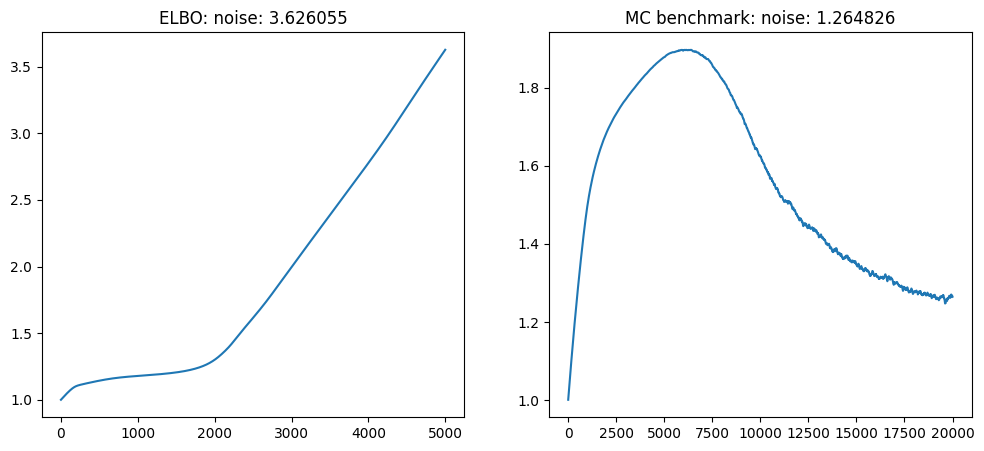

In [331]:
params_elbo = pd.DataFrame(params_log).T
print(params_elbo.columns)
fig, axis = plt.subplots(1,2, figsize=(12,5))
col_ = 'noise'
params_elbo[col_].plot(title='ELBO: %s: %.6f'%(col_, params_elbo[col_].tail(1).values[0]), ax=axis[0])
params_mc_benchmark[col_].plot(title='MC benchmark: %s: %.6f'%(col_, params_mc_benchmark[col_].tail(1).values[0]), ax=axis[1])

In [ ]:
# MC benchmark
# noise.noise : 1.1169327
# mean_module.constant:  -0.2968234121799469
# covar_module.outputscale: 14.430706024169922
# covar_module.base_kernel.lengthscale: 0.09698801

In [318]:
print_module(likelihood)
print_module(model)

noise.noise                         (1,)
[3.6260552]
variational_strategy._variational_distribution.variational_mean (15,)
[-4.5387995e-01 -9.3477167e-02 -1.2209936e+00  1.4531179e-01
  5.3794366e-01 -2.4914984e-01 -1.0723885e-01  1.0060805e+00
  2.5194019e-01  6.4620078e-02 -1.4599733e-01 -9.2287838e-02
 -6.6617440e-04  5.1596124e-02 -7.8108919e-01]
variational_strategy._variational_distribution.chol_variational_covar (15, 15)
[[ 2.45412737e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.41142718e-02  3.06569606e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.69338363e-01  1.51620749e-02  4.43052143e-01  0.00000000e+00
   0

In [319]:
model.variational_strategy._variational_distribution.variational_mean

Parameter containing:
tensor([-4.5388e-01, -9.3477e-02, -1.2210e+00,  1.4531e-01,  5.3794e-01,
        -2.4915e-01, -1.0724e-01,  1.0061e+00,  2.5194e-01,  6.4620e-02,
        -1.4600e-01, -9.2288e-02, -6.6617e-04,  5.1596e-02, -7.8109e-01],
       requires_grad=True)

In [320]:
model.eval()
likelihood.eval()

f_preds = model(domain[:,None])
y_preds = likelihood(f_preds)

f_mean = f_preds.loc
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix

N_samples = 1000
breakpoints = torch.linspace(0, 1, N_samples+1)[:-1]
breakpoints = breakpoints + breakpoints[1] * torch.rand_like(breakpoints)

with torch.no_grad():
    pred_samples = torch.distributions.Normal(f_mean, f_var.sqrt()).icdf(breakpoints[:,None])

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(


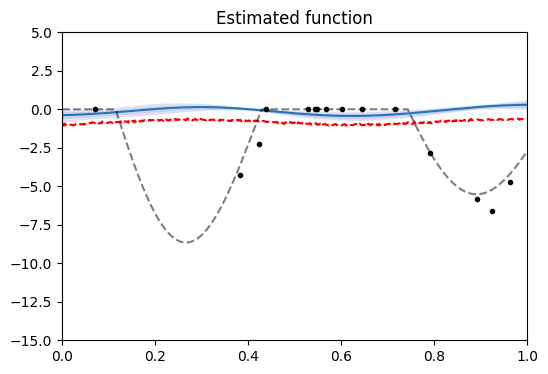

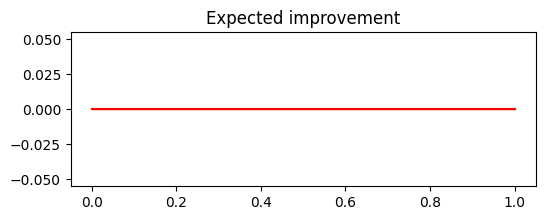

In [321]:
def plot_result(pred_samples, censored=False):
    if censored:
        c_pred = pred_samples > MAX_VALUE
        pred_samples[c_pred] = MAX_VALUE
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
      pred_median = np.median(pred_samples, axis=0)
      pred_quantiles = np.quantile(pred_samples, [0.025, 0.15, 0.85, 0.975], axis=0)

      plt.figure(figsize=(6, 4))
      plt.plot(domain, pred_median)

      plt.fill_between(domain, pred_quantiles[0], pred_quantiles[-1], alpha=0.1, color='#33c');
      plt.fill_between(domain, pred_quantiles[1], pred_quantiles[-2], alpha=0.1, color='#33c');
      plt.plot(domain, y_preds.sample_n(n=100).mean([0,1]).numpy(force=True), 'r--')

      plt.plot(x, y, 'k.');
      plt.plot(domain, noise_free_target(domain).clamp_max(MAX_VALUE), 'k--', alpha=0.5);
      plt.xlim(0, 1);
      plt.ylim(-15, 5);
      plt.title("Estimated function")

      plt.figure(figsize=(6, 2))
      plt.title("Expected improvement")
      EI =  -(pred_samples*(pred_samples < y.min()).float()).mean(0)
      plt.plot(domain, EI, 'r');
      plt.fill_between(domain, torch.zeros_like(domain), EI, color='r', alpha=0.5)

   # return f_covar, pred_samples

plot_result(pred_samples)

In [ ]:
# u,d = f_preds.confidence_region()
# plt.plot(domain, f_preds.loc.numpy(force=True))
# plt.fill_between(domain, u.numpy(force=True), d.numpy(force=True), alpha=0.1, color='#33c')
# plt.plot(domain, y_preds.sample_n(n=100).mean([0,1]).numpy(force=True), 'r--')
# plt.plot(x, y, 'k.');
# plt.plot(domain, noise_free_target(domain).clamp_max(MAX_VALUE), 'k--', alpha=0.5);

# MC Simulation

In [295]:
from gpytorch.models import ApproximateGP # handles basic variational inference
from gpytorch.variational import CholeskyVariationalDistribution # distribution of the approximation q(f)
from gpytorch.variational import VariationalStrategy # use when larger sample - transform q(u) to q(f) over inducing points

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        # defines approximation
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points,
                                                   variational_distribution, learn_inducing_locations=False)
        super(GPModel, self).__init__(variational_strategy)
        # defines the GP
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


model = GPModel(inducing_points=x[:,None])
# ElBO Likelihood
likelihood = CensoredGaussianLikelihood(low=-1000., high=MAX_VALUE)

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [296]:
print_module(model)

variational_strategy._variational_distribution.variational_mean (15,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
variational_strategy._variational_distribution.chol_variational_covar (15, 15)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
mean_module.constant                ()
0.0
covar_module.outputscale            ()
0

In [297]:
num_epochs = 30000
pbar = tqdm.tqdm(range(num_epochs), position=0, leave=True)

model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.001)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, beta=1., num_data=y.size(0))

params_log = dict()
for iter in pbar:
    optimizer.zero_grad();
    y_pred = model(x[:,None])
    loss = -mll(y_pred, y)
    loss.backward()
    optimizer.step()
    params_log[iter] = {
        'loss': loss.item(),
        'outscale': model.covar_module.outputscale.item(),
        'mean_module': model.mean_module.constant.item(),
        'noise': likelihood.noise.noise.item()
        }

    if iter%100==0:
      for key, val in params_log[iter].items():
        print(key, val)

  0%|          | 20/30000 [00:00<05:04, 98.33it/s]

loss 1.8592976331710815
outscale 0.6926472783088684
mean_module 0.0009999998146668077
noise 1.0006321668624878


  0%|          | 121/30000 [00:01<04:49, 103.32it/s]

loss 1.3199800252914429
outscale 0.6425414085388184
mean_module 0.11251594871282578
noise 1.0614951848983765


  1%|          | 207/30000 [00:02<06:42, 74.07it/s]

loss 0.38027673959732056
outscale 0.5919874906539917
mean_module 0.237984299659729
noise 1.104710340499878


  1%|          | 313/30000 [00:03<06:58, 71.01it/s]

loss 0.15738683938980103
outscale 0.5651132464408875
mean_module 0.28506556153297424
noise 1.1227127313613892


  1%|▏         | 411/30000 [00:04<05:12, 94.80it/s]

loss 0.13118717074394226
outscale 0.5484321117401123
mean_module 0.30070605874061584
noise 1.1368082761764526


  2%|▏         | 514/30000 [00:05<04:29, 109.31it/s]

loss 0.1175428032875061
outscale 0.5336617231369019
mean_module 0.3117842376232147
noise 1.1505435705184937


  2%|▏         | 620/30000 [00:06<04:25, 110.52it/s]

loss 0.10744714736938477
outscale 0.5196858048439026
mean_module 0.321880578994751
noise 1.1641143560409546


  2%|▏         | 712/30000 [00:07<04:31, 107.94it/s]

loss 0.09911759942770004
outscale 0.5061945915222168
mean_module 0.332123339176178
noise 1.1774414777755737


  3%|▎         | 813/30000 [00:08<04:47, 101.59it/s]

loss 0.09195821732282639
outscale 0.4930979609489441
mean_module 0.34292441606521606
noise 1.1903915405273438


  3%|▎         | 912/30000 [00:09<04:38, 104.46it/s]

loss 0.08571383357048035
outscale 0.480385959148407
mean_module 0.35436540842056274
noise 1.2028424739837646


  3%|▎         | 1013/30000 [00:10<04:31, 106.83it/s]

loss 0.08025448769330978
outscale 0.4680710434913635
mean_module 0.3663468658924103
noise 1.214720368385315


  4%|▎         | 1113/30000 [00:11<04:51, 98.96it/s] 

loss 0.07549148052930832
outscale 0.4561566114425659
mean_module 0.3786783814430237
noise 1.226019263267517


  4%|▍         | 1221/30000 [00:12<04:36, 103.90it/s]

loss 0.07133327424526215
outscale 0.4446205198764801
mean_module 0.39114782214164734
noise 1.2368028163909912


  4%|▍         | 1321/30000 [00:13<04:26, 107.52it/s]

loss 0.06767050921916962
outscale 0.4334132671356201
mean_module 0.40356916189193726
noise 1.2471896409988403


  5%|▍         | 1409/30000 [00:14<05:25, 87.95it/s]

loss 0.0643831193447113
outscale 0.42246800661087036
mean_module 0.41579440236091614
noise 1.2573298215866089


  5%|▌         | 1506/30000 [00:15<07:31, 63.13it/s]

loss 0.06135719269514084
outscale 0.4117175340652466
mean_module 0.4276934266090393
noise 1.2673842906951904


  5%|▌         | 1608/30000 [00:17<08:19, 56.82it/s]

loss 0.05849311500787735
outscale 0.40111005306243896
mean_module 0.4391164481639862
noise 1.2775124311447144


  6%|▌         | 1710/30000 [00:19<06:54, 68.24it/s]

loss 0.05570495128631592
outscale 0.39061975479125977
mean_module 0.4498511254787445
noise 1.2878741025924683


  6%|▌         | 1818/30000 [00:20<04:31, 103.95it/s]

loss 0.052909716963768005
outscale 0.3802538216114044
mean_module 0.4595726430416107
noise 1.2986377477645874


  6%|▋         | 1919/30000 [00:21<04:24, 105.99it/s]

loss 0.05000600963830948
outscale 0.3700593411922455
mean_module 0.46777403354644775
noise 1.3099993467330933


  7%|▋         | 2016/30000 [00:22<06:27, 72.21it/s]

loss 0.04683546721935272
outscale 0.3601350784301758
mean_module 0.47364962100982666
noise 1.3222136497497559


  7%|▋         | 2107/30000 [00:24<08:11, 56.76it/s]

loss 0.043099433183670044
outscale 0.35065385699272156
mean_module 0.47587713599205017
noise 1.3356508016586304


  7%|▋         | 2220/30000 [00:25<04:30, 102.84it/s]

loss 0.038153618574142456
outscale 0.3419056534767151
mean_module 0.4721936285495758
noise 1.350898265838623


  8%|▊         | 2321/30000 [00:26<04:21, 105.97it/s]

loss 0.03045976161956787
outscale 0.33436593413352966
mean_module 0.4585619270801544
noise 1.3689700365066528


  8%|▊         | 2420/30000 [00:27<04:27, 103.20it/s]

loss 0.01608552411198616
outscale 0.3287453055381775
mean_module 0.4277079105377197
noise 1.391721248626709


  8%|▊         | 2508/30000 [00:28<05:56, 77.21it/s]

loss -0.014827556908130646
outscale 0.32569602131843567
mean_module 0.36790475249290466
noise 1.4225504398345947


  9%|▊         | 2606/30000 [00:30<13:41, 33.35it/s]

loss -0.08184777945280075
outscale 0.32438164949417114
mean_module 0.2676032483577728
noise 1.4665430784225464


  9%|▉         | 2705/30000 [00:32<07:26, 61.20it/s]

loss -0.20277339220046997
outscale 0.3203337490558624
mean_module 0.1287737637758255
noise 1.527866244316101


  9%|▉         | 2804/30000 [00:33<06:42, 67.60it/s]

loss -0.3745148777961731
outscale 0.30416181683540344
mean_module -0.019245069473981857
noise 1.6105834245681763


 10%|▉         | 2912/30000 [00:35<04:43, 95.50it/s]

loss -0.5562418103218079
outscale 0.2752363979816437
mean_module -0.1296377331018448
noise 1.7150278091430664


 10%|█         | 3023/30000 [00:36<04:12, 107.03it/s]

loss -0.6444119215011597
outscale 0.25055280327796936
mean_module -0.1424199938774109
noise 1.82982337474823


 10%|█         | 3114/30000 [00:37<04:21, 102.80it/s]

loss -0.6940411329269409
outscale 0.23264047503471375
mean_module -0.12371421605348587
noise 1.9417455196380615


 11%|█         | 3216/30000 [00:38<04:14, 105.31it/s]

loss -0.7324622869491577
outscale 0.21774010360240936
mean_module -0.10815620422363281
noise 2.0492961406707764


 11%|█         | 3322/30000 [00:39<04:10, 106.62it/s]

loss -0.766925573348999
outscale 0.20447905361652374
mean_module -0.09786365181207657
noise 2.1539745330810547


 11%|█▏        | 3413/30000 [00:40<04:17, 103.33it/s]

loss -0.8025763034820557
outscale 0.19192983210086823
mean_module -0.09552889317274094
noise 2.258941411972046


 12%|█▏        | 3517/30000 [00:41<04:06, 107.47it/s]

loss -0.881184458732605
outscale 0.17888949811458588
mean_module -0.12565158307552338
noise 2.3766629695892334


 12%|█▏        | 3611/30000 [00:42<03:57, 111.27it/s]

loss -0.9524562954902649
outscale 0.1696673035621643
mean_module -0.14940018951892853
noise 2.4978015422821045


 12%|█▏        | 3715/30000 [00:43<05:47, 75.71it/s]

loss -1.0099008083343506
outscale 0.16345158219337463
mean_module -0.16864517331123352
noise 2.6148977279663086


 13%|█▎        | 3808/30000 [00:44<06:24, 68.05it/s]

loss -1.057241439819336
outscale 0.15918880701065063
mean_module -0.18306180834770203
noise 2.7270333766937256


 13%|█▎        | 3918/30000 [00:45<04:27, 97.67it/s]

loss -1.0973763465881348
outscale 0.15622495114803314
mean_module -0.19338731467723846
noise 2.8345236778259277


 13%|█▎        | 4019/30000 [00:46<04:05, 105.77it/s]

loss -1.1324639320373535
outscale 0.15417368710041046
mean_module -0.200747549533844
noise 2.9379780292510986


 14%|█▎        | 4112/30000 [00:47<04:01, 107.26it/s]

loss -1.1639814376831055
outscale 0.15278837084770203
mean_module -0.20620405673980713
noise 3.038015842437744


 14%|█▍        | 4214/30000 [00:48<04:00, 107.11it/s]

loss -1.1929056644439697
outscale 0.1518925577402115
mean_module -0.21052920818328857
noise 3.1352062225341797


 14%|█▍        | 4313/30000 [00:49<04:12, 101.92it/s]

loss -1.2198797464370728
outscale 0.15135037899017334
mean_module -0.2141829878091812
noise 3.230038642883301


 15%|█▍        | 4415/30000 [00:50<04:23, 96.99it/s] 

loss -1.245330572128296
outscale 0.1510549932718277
mean_module -0.21739600598812103
noise 3.322920799255371


 15%|█▌        | 4513/30000 [00:51<04:07, 102.99it/s]

loss -1.2695434093475342
outscale 0.15092286467552185
mean_module -0.22026559710502625
noise 3.4141862392425537


 15%|█▌        | 4616/30000 [00:52<03:50, 110.07it/s]

loss -1.2927172183990479
outscale 0.15089036524295807
mean_module -0.22282926738262177
noise 3.504108428955078


 16%|█▌        | 4717/30000 [00:53<04:13, 99.66it/s] 

loss -1.314995288848877
outscale 0.1509096920490265
mean_module -0.22510623931884766
noise 3.592911958694458


 16%|█▌        | 4821/30000 [00:54<03:56, 106.45it/s]

loss -1.3364874124526978
outscale 0.1509455442428589
mean_module -0.2271178662776947
noise 3.6807823181152344


 16%|█▋        | 4916/30000 [00:55<05:02, 83.03it/s]

loss -1.357282280921936
outscale 0.15097151696681976
mean_module -0.22889401018619537
noise 3.767875909805298


 17%|█▋        | 5008/30000 [00:56<05:53, 70.73it/s]

loss -1.377456545829773
outscale 0.15096691250801086
mean_module -0.23047246038913727
noise 3.8543312549591064


 17%|█▋        | 5116/30000 [00:58<04:26, 93.24it/s]

loss -1.3970781564712524
outscale 0.15091447532176971
mean_module -0.23189513385295868
noise 3.9402735233306885


 17%|█▋        | 5214/30000 [00:59<03:53, 106.07it/s]

loss -1.416210412979126
outscale 0.15079739689826965
mean_module -0.23320633172988892
noise 4.025818824768066


 18%|█▊        | 5316/30000 [01:00<03:47, 108.29it/s]

loss -1.4349141120910645
outscale 0.1505986899137497
mean_module -0.2344493865966797
noise 4.111082077026367


 18%|█▊        | 5421/30000 [01:01<03:49, 107.27it/s]

loss -1.4532490968704224
outscale 0.1502981185913086
mean_module -0.2356686294078827
noise 4.196177005767822


 18%|█▊        | 5511/30000 [01:01<03:53, 104.91it/s]

loss -1.4712786674499512
outscale 0.1498710662126541
mean_module -0.23691028356552124
noise 4.281227111816406


 19%|█▊        | 5610/30000 [01:02<04:25, 91.75it/s]

loss -1.4890741109848022
outscale 0.14928482472896576
mean_module -0.2382308542728424
noise 4.3663787841796875


 19%|█▉        | 5719/30000 [01:03<04:00, 100.78it/s]

loss -1.5067229270935059
outscale 0.14849406480789185
mean_module -0.2397100031375885
noise 4.451816558837891


 19%|█▉        | 5820/30000 [01:04<03:39, 110.34it/s]

loss -1.5243477821350098
outscale 0.14742860198020935
mean_module -0.24149541556835175
noise 4.537800312042236


 20%|█▉        | 5912/30000 [01:05<03:42, 108.50it/s]

loss -1.5421655178070068
outscale 0.14595729112625122
mean_module -0.24398094415664673
noise 4.624783992767334


 20%|██        | 6013/30000 [01:06<04:06, 97.40it/s] 

loss -1.5608859062194824
outscale 0.143626406788826
mean_module -0.2497662454843521
noise 4.714029788970947


 20%|██        | 6114/30000 [01:07<03:40, 108.09it/s]

loss -1.6522818803787231
outscale 0.12954674661159515
mean_module -0.3974211812019348
noise 4.818987846374512


 21%|██        | 6217/30000 [01:09<04:58, 79.73it/s]

loss -1.8524740934371948
outscale 0.10846606642007828
mean_module -0.7047200202941895
noise 4.945995807647705


 21%|██        | 6310/30000 [01:10<05:47, 68.23it/s]

loss -1.9412764310836792
outscale 0.09976157546043396
mean_module -0.8789413571357727
noise 5.062871932983398


 21%|██▏       | 6420/30000 [01:11<03:42, 106.16it/s]

loss -1.9973840713500977
outscale 0.0939430445432663
mean_module -0.9985512495040894
noise 5.172107696533203


 22%|██▏       | 6515/30000 [01:12<03:36, 108.59it/s]

loss -2.040004253387451
outscale 0.08911553770303726
mean_module -1.0897419452667236
noise 5.276218891143799


 22%|██▏       | 6622/30000 [01:13<03:35, 108.46it/s]

loss -2.0751543045043945
outscale 0.08496051281690598
mean_module -1.1626417636871338
noise 5.37654447555542


 22%|██▏       | 6717/30000 [01:14<03:28, 111.62it/s]

loss -2.105492353439331
outscale 0.08140791952610016
mean_module -1.2224087715148926
noise 5.473931789398193


 23%|██▎       | 6813/30000 [01:15<03:26, 112.07it/s]

loss -2.1324615478515625
outscale 0.07842537015676498
mean_module -1.2720863819122314
noise 5.568966388702393


 23%|██▎       | 6920/30000 [01:16<03:26, 111.87it/s]

loss -2.1569576263427734
outscale 0.07598273456096649
mean_module -1.3136662244796753
noise 5.662075996398926


 23%|██▎       | 7016/30000 [01:16<03:25, 111.81it/s]

loss -2.179584264755249
outscale 0.07405047118663788
mean_module -1.3485589027404785
noise 5.753589153289795


 24%|██▎       | 7120/30000 [01:17<03:31, 108.39it/s]

loss -2.2007713317871094
outscale 0.07260319590568542
mean_module -1.3778314590454102
noise 5.843764305114746


 24%|██▍       | 7215/30000 [01:18<03:27, 109.91it/s]

loss -2.220829725265503
outscale 0.07162363827228546
mean_module -1.4023330211639404
noise 5.932808876037598


 24%|██▍       | 7316/30000 [01:19<03:45, 100.40it/s]

loss -2.2399909496307373
outscale 0.07110577821731567
mean_module -1.422766089439392
noise 6.020890712738037


 25%|██▍       | 7419/30000 [01:20<03:26, 109.17it/s]

loss -2.258430242538452
outscale 0.07105868309736252
mean_module -1.4397302865982056
noise 6.108144760131836


 25%|██▌       | 7511/30000 [01:21<04:40, 80.27it/s]

loss -2.2762808799743652
outscale 0.07151109725236893
mean_module -1.4537463188171387
noise 6.1946892738342285


 25%|██▌       | 7612/30000 [01:23<05:26, 68.62it/s]

loss -2.2936501502990723
outscale 0.07251767814159393
mean_module -1.4652739763259888
noise 6.28061580657959


 26%|██▌       | 7718/30000 [01:24<03:28, 106.90it/s]

loss -2.31062650680542
outscale 0.0741690918803215
mean_module -1.4747231006622314
noise 6.366003036499023


 26%|██▌       | 7822/30000 [01:25<03:24, 108.59it/s]

loss -2.3272900581359863
outscale 0.07660673558712006
mean_module -1.4824601411819458
noise 6.450915336608887


 26%|██▋       | 7912/30000 [01:26<03:28, 106.13it/s]

loss -2.343719959259033
outscale 0.08004435151815414
mean_module -1.4888169765472412
noise 6.535400867462158


 27%|██▋       | 8011/30000 [01:27<03:49, 95.81it/s]

loss -2.360001802444458
outscale 0.08480064570903778
mean_module -1.4940946102142334
noise 6.61949348449707


 27%|██▋       | 8114/30000 [01:28<03:21, 108.39it/s]

loss -2.3762338161468506
outscale 0.09134282171726227
mean_module -1.4985793828964233
noise 6.703213214874268


 27%|██▋       | 8217/30000 [01:29<03:30, 103.27it/s]

loss -2.392534017562866
outscale 0.10033983737230301
mean_module -1.5025634765625
noise 6.786563396453857


 28%|██▊       | 8316/30000 [01:30<03:29, 103.72it/s]

loss -2.4090206623077393
outscale 0.11268268525600433
mean_module -1.5063936710357666
noise 6.869529724121094


 28%|██▊       | 8420/30000 [01:31<03:23, 106.08it/s]

loss -2.4257423877716064
outscale 0.12932339310646057
mean_module -1.5105797052383423
noise 6.952077388763428


 28%|██▊       | 8520/30000 [01:32<03:23, 105.42it/s]

loss -2.4425840377807617
outscale 0.15077975392341614
mean_module -1.516050100326538
noise 7.034163475036621


 29%|██▊       | 8620/30000 [01:33<03:31, 101.19it/s]

loss -2.4592416286468506
outscale 0.17652584612369537
mean_module -1.524507761001587
noise 7.115753173828125


 29%|██▉       | 8711/30000 [01:34<04:31, 78.35it/s]

loss -2.4753072261810303
outscale 0.20497187972068787
mean_module -1.5379475355148315
noise 7.196846008300781


 29%|██▉       | 8810/30000 [01:35<04:55, 71.67it/s]

loss -2.490501880645752
outscale 0.2343991994857788
mean_module -1.5568517446517944
noise 7.277501583099365


 30%|██▉       | 8919/30000 [01:37<03:35, 97.96it/s] 

loss -2.5047755241394043
outscale 0.26360589265823364
mean_module -1.5797773599624634
noise 7.357824325561523


 30%|███       | 9019/30000 [01:38<03:23, 102.96it/s]

loss -2.518209934234619
outscale 0.29177263379096985
mean_module -1.6046898365020752
noise 7.437938690185547


 30%|███       | 9123/30000 [01:39<03:11, 109.25it/s]

loss -2.5309298038482666
outscale 0.3183126151561737
mean_module -1.629841923713684
noise 7.5179595947265625


 31%|███       | 9218/30000 [01:39<03:08, 110.32it/s]

loss -2.5430634021759033
outscale 0.3428122401237488
mean_module -1.6539839506149292
noise 7.597981929779053


 31%|███       | 9324/30000 [01:40<03:00, 114.30it/s]

loss -2.5547258853912354
outscale 0.3649882376194
mean_module -1.6763216257095337
noise 7.6780877113342285


 31%|███▏      | 9418/30000 [01:41<03:04, 111.51it/s]

loss -2.5660130977630615
outscale 0.3846556544303894
mean_module -1.696403980255127
noise 7.758340835571289


 32%|███▏      | 9518/30000 [01:42<03:13, 105.89it/s]

loss -2.5770034790039062
outscale 0.4017055928707123
mean_module -1.7140172719955444
noise 7.838797569274902


 32%|███▏      | 9619/30000 [01:43<03:32, 95.69it/s]

loss -2.5877578258514404
outscale 0.41608986258506775
mean_module -1.7290998697280884
noise 7.919500350952148


 32%|███▏      | 9719/30000 [01:44<03:09, 106.97it/s]

loss -2.598323106765747
outscale 0.4278104901313782
mean_module -1.7416930198669434
noise 8.000481605529785


 33%|███▎      | 9818/30000 [01:45<03:39, 92.11it/s]

loss -2.6087353229522705
outscale 0.4369123578071594
mean_module -1.7518984079360962
noise 8.081765174865723


 33%|███▎      | 9908/30000 [01:46<03:42, 90.10it/s] 

loss -2.619020938873291
outscale 0.4434788227081299
mean_module -1.7598549127578735
noise 8.163376808166504


 33%|███▎      | 10009/30000 [01:48<04:22, 76.06it/s]

loss -2.629202365875244
outscale 0.4476277828216553
mean_module -1.765722393989563
noise 8.245325088500977


 34%|███▎      | 10112/30000 [01:49<04:49, 68.60it/s]

loss -2.639293670654297
outscale 0.44950971007347107
mean_module -1.7696690559387207
noise 8.327625274658203


 34%|███▍      | 10212/30000 [01:50<03:09, 104.34it/s]

loss -2.649306058883667
outscale 0.44930243492126465
mean_module -1.771867275238037
noise 8.41027545928955


 34%|███▍      | 10313/30000 [01:51<03:04, 106.59it/s]

loss -2.6592493057250977
outscale 0.4472072720527649
mean_module -1.7724874019622803
noise 8.49328327178955


 35%|███▍      | 10415/30000 [01:52<03:22, 96.56it/s] 

loss -2.669128656387329
outscale 0.4434430003166199
mean_module -1.771697998046875
noise 8.576650619506836


 35%|███▌      | 10516/30000 [01:53<03:03, 106.43it/s]

loss -2.6789474487304688
outscale 0.438238263130188
mean_module -1.76966392993927
noise 8.66036605834961


 35%|███▌      | 10618/30000 [01:54<02:57, 109.50it/s]

loss -2.688706874847412
outscale 0.43182551860809326
mean_module -1.7665469646453857
noise 8.744426727294922


 36%|███▌      | 10721/30000 [01:55<02:54, 110.43it/s]

loss -2.69840931892395
outscale 0.424433171749115
mean_module -1.7625025510787964
noise 8.828826904296875


 36%|███▌      | 10813/30000 [01:56<03:00, 106.53it/s]

loss -2.70805287361145
outscale 0.416279137134552
mean_module -1.7576806545257568
noise 8.913553237915039


 36%|███▋      | 10918/30000 [01:57<02:54, 109.42it/s]

loss -2.717637538909912
outscale 0.40756654739379883
mean_module -1.7522238492965698
noise 8.998594284057617


 37%|███▋      | 11023/30000 [01:57<02:56, 107.32it/s]

loss -2.7271616458892822
outscale 0.39847928285598755
mean_module -1.7462658882141113
noise 9.083943367004395


 37%|███▋      | 11118/30000 [01:58<02:50, 110.75it/s]

loss -2.7366232872009277
outscale 0.38917970657348633
mean_module -1.7399307489395142
noise 9.16958236694336


 37%|███▋      | 11211/30000 [01:59<03:51, 81.08it/s]

loss -2.7460219860076904
outscale 0.3798075020313263
mean_module -1.7333310842514038
noise 9.255500793457031


 38%|███▊      | 11308/30000 [02:01<03:54, 79.82it/s]

loss -2.7553555965423584
outscale 0.3704797029495239
mean_module -1.7265666723251343
noise 9.341686248779297


 38%|███▊      | 11414/30000 [02:02<03:57, 78.33it/s]

loss -2.7646219730377197
outscale 0.3612912893295288
mean_module -1.7197246551513672
noise 9.42811393737793


 38%|███▊      | 11517/30000 [02:03<02:49, 108.84it/s]

loss -2.7738208770751953
outscale 0.35231685638427734
mean_module -1.7128808498382568
noise 9.514784812927246


 39%|███▊      | 11619/30000 [02:04<02:51, 106.91it/s]

loss -2.7829506397247314
outscale 0.3436126708984375
mean_module -1.706096887588501
noise 9.60167407989502


 39%|███▉      | 11710/30000 [02:05<02:53, 105.70it/s]

loss -2.792010545730591
outscale 0.335218608379364
mean_module -1.6994224786758423
noise 9.68877124786377


 39%|███▉      | 11812/30000 [02:06<02:50, 106.76it/s]

loss -2.800999879837036
outscale 0.3271603584289551
mean_module -1.6928973197937012
noise 9.776067733764648


 40%|███▉      | 11919/30000 [02:07<02:49, 106.84it/s]

loss -2.809918165206909
outscale 0.31945204734802246
mean_module -1.6865507364273071
noise 9.863550186157227


 40%|████      | 12020/30000 [02:08<02:58, 100.84it/s]

loss -2.8187649250030518
outscale 0.31209826469421387
mean_module -1.6804022789001465
noise 9.95120620727539


 40%|████      | 12112/30000 [02:09<04:25, 67.41it/s]

loss -2.8275399208068848
outscale 0.3050961494445801
mean_module -1.6744651794433594
noise 10.039021492004395


 41%|████      | 12207/30000 [02:10<04:32, 65.19it/s]

loss -2.8362433910369873
outscale 0.2984371483325958
mean_module -1.668745756149292
noise 10.126993179321289


 41%|████      | 12316/30000 [02:11<02:51, 103.32it/s]

loss -2.8448750972747803
outscale 0.2921087145805359
mean_module -1.663245677947998
noise 10.215108871459961


 41%|████▏     | 12414/30000 [02:13<03:47, 77.27it/s]

loss -2.853435754776001
outscale 0.28609538078308105
mean_module -1.6579625606536865
noise 10.303363800048828


 42%|████▏     | 12514/30000 [02:14<04:11, 69.54it/s]

loss -2.8619253635406494
outscale 0.2803802788257599
mean_module -1.6528910398483276
noise 10.391738891601562


 42%|████▏     | 12621/30000 [02:15<02:52, 100.99it/s]

loss -2.8703439235687256
outscale 0.2749457359313965
mean_module -1.648024082183838
noise 10.480247497558594


 42%|████▏     | 12712/30000 [02:16<02:40, 107.69it/s]

loss -2.8786938190460205
outscale 0.2697736322879791
mean_module -1.6433522701263428
noise 10.56887149810791


 43%|████▎     | 12814/30000 [02:17<02:42, 105.82it/s]

loss -2.886972188949585
outscale 0.26484671235084534
mean_module -1.6388672590255737
noise 10.657605171203613


 43%|████▎     | 12916/30000 [02:18<02:39, 106.94it/s]

loss -2.8951821327209473
outscale 0.26014792919158936
mean_module -1.6345592737197876
noise 10.746443748474121


 43%|████▎     | 13018/30000 [02:19<02:41, 105.13it/s]

loss -2.9033236503601074
outscale 0.2556615471839905
mean_module -1.630418300628662
noise 10.835383415222168


 44%|████▎     | 13113/30000 [02:20<02:33, 109.81it/s]

loss -2.9113972187042236
outscale 0.2513728141784668
mean_module -1.6264355182647705
noise 10.924421310424805


 44%|████▍     | 13218/30000 [02:21<02:31, 110.90it/s]

loss -2.919403314590454
outscale 0.24726775288581848
mean_module -1.6226019859313965
noise 11.013554573059082


 44%|████▍     | 13319/30000 [02:22<02:39, 104.47it/s]

loss -2.9273438453674316
outscale 0.24333368241786957
mean_module -1.618909239768982
noise 11.102779388427734


 45%|████▍     | 13416/30000 [02:23<02:44, 100.61it/s]

loss -2.935218095779419
outscale 0.2395588606595993
mean_module -1.615349292755127
noise 11.192091941833496


 45%|████▌     | 13517/30000 [02:24<03:03, 90.01it/s]

loss -2.9430270195007324
outscale 0.2359325885772705
mean_module -1.6119149923324585
noise 11.281489372253418


 45%|████▌     | 13610/30000 [02:25<03:10, 86.25it/s]

loss -2.9507715702056885
outscale 0.23244492709636688
mean_module -1.6085991859436035
noise 11.37096881866455


 46%|████▌     | 13709/30000 [02:26<03:33, 76.25it/s]

loss -2.9584522247314453
outscale 0.229086771607399
mean_module -1.605396032333374
noise 11.460525512695312


 46%|████▌     | 13815/30000 [02:28<03:39, 73.77it/s]

loss -2.9660720825195312
outscale 0.22584986686706543
mean_module -1.6022993326187134
noise 11.550169944763184


 46%|████▋     | 13918/30000 [02:29<02:36, 102.90it/s]

loss -2.973628520965576
outscale 0.22272653877735138
mean_module -1.5993038415908813
noise 11.639897346496582


 47%|████▋     | 14012/30000 [02:30<02:39, 100.18it/s]

loss -2.9811251163482666
outscale 0.21970966458320618
mean_module -1.5964040756225586
noise 11.729696273803711


 47%|████▋     | 14113/30000 [02:31<02:33, 103.49it/s]

loss -2.9885599613189697
outscale 0.2167927324771881
mean_module -1.5935956239700317
noise 11.819565773010254


 47%|████▋     | 14214/30000 [02:32<02:27, 106.69it/s]

loss -2.9959349632263184
outscale 0.21396952867507935
mean_module -1.5908734798431396
noise 11.909501075744629


 48%|████▊     | 14318/30000 [02:33<02:26, 107.09it/s]

loss -3.003253221511841
outscale 0.21123459935188293
mean_module -1.588234305381775
noise 11.999526977539062


 48%|████▊     | 14421/30000 [02:34<02:25, 107.04it/s]

loss -3.010512351989746
outscale 0.20858293771743774
mean_module -1.5856738090515137
noise 12.089621543884277


 48%|████▊     | 14514/30000 [02:34<02:17, 112.53it/s]

loss -3.017714023590088
outscale 0.20600944757461548
mean_module -1.5831882953643799
noise 12.179777145385742


 49%|████▊     | 14621/30000 [02:35<02:18, 111.04it/s]

loss -3.0248587131500244
outscale 0.2035095989704132
mean_module -1.5807745456695557
noise 12.269994735717773


 49%|████▉     | 14713/30000 [02:36<02:19, 109.54it/s]

loss -3.031949520111084
outscale 0.2010793685913086
mean_module -1.5784296989440918
noise 12.360304832458496


 49%|████▉     | 14816/30000 [02:37<02:20, 107.89it/s]

loss -3.0389842987060547
outscale 0.19871483743190765
mean_module -1.5761500597000122
noise 12.45067024230957


 50%|████▉     | 14910/30000 [02:38<03:01, 82.92it/s]

loss -3.045963764190674
outscale 0.19641220569610596
mean_module -1.5739333629608154
noise 12.541090965270996


 50%|█████     | 15015/30000 [02:40<03:19, 75.05it/s]

loss -3.052891254425049
outscale 0.19416792690753937
mean_module -1.5717765092849731
noise 12.631593704223633


 50%|█████     | 15119/30000 [02:41<02:44, 90.45it/s]

loss -3.059765338897705
outscale 0.19197909533977509
mean_module -1.5696778297424316
noise 12.722161293029785


 51%|█████     | 15220/30000 [02:42<02:20, 105.32it/s]

loss -3.066586494445801
outscale 0.18984244763851166
mean_module -1.5676343441009521
noise 12.81277847290039


 51%|█████     | 15311/30000 [02:43<02:18, 105.94it/s]

loss -3.073357105255127
outscale 0.18775498867034912
mean_module -1.5656436681747437
noise 12.903472900390625


 51%|█████▏    | 15412/30000 [02:44<02:17, 105.85it/s]

loss -3.0800766944885254
outscale 0.1857142150402069
mean_module -1.5637038946151733
noise 12.994232177734375


 52%|█████▏    | 15514/30000 [02:45<02:15, 107.19it/s]

loss -3.0867457389831543
outscale 0.18371747434139252
mean_module -1.561813235282898
noise 13.085037231445312


 52%|█████▏    | 15618/30000 [02:46<02:11, 109.50it/s]

loss -3.0933661460876465
outscale 0.18176217377185822
mean_module -1.5599700212478638
noise 13.175922393798828


 52%|█████▏    | 15711/30000 [02:47<02:10, 109.68it/s]

loss -3.0999372005462646
outscale 0.1798461377620697
mean_module -1.5581722259521484
noise 13.266865730285645


 53%|█████▎    | 15812/30000 [02:47<02:13, 105.98it/s]

loss -3.106459379196167
outscale 0.1779671162366867
mean_module -1.5564173460006714
noise 13.357850074768066


 53%|█████▎    | 15915/30000 [02:48<02:09, 108.40it/s]

loss -3.11293625831604
outscale 0.17612287402153015
mean_module -1.5547051429748535
noise 13.448925971984863


 53%|█████▎    | 16014/30000 [02:49<02:14, 103.97it/s]

loss -3.1193645000457764
outscale 0.17431163787841797
mean_module -1.5530328750610352
noise 13.540043830871582


 54%|█████▎    | 16113/30000 [02:50<02:22, 97.15it/s]

loss -3.125746488571167
outscale 0.17253097891807556
mean_module -1.551400065422058
noise 13.63121509552002


 54%|█████▍    | 16212/30000 [02:52<02:53, 79.37it/s]

loss -3.1320841312408447
outscale 0.17077931761741638
mean_module -1.5498051643371582
noise 13.722465515136719


 54%|█████▍    | 16313/30000 [02:53<03:20, 68.34it/s]

loss -3.1383743286132812
outscale 0.16905498504638672
mean_module -1.548246145248413
noise 13.813750267028809


 55%|█████▍    | 16417/30000 [02:54<02:14, 101.02it/s]

loss -3.144622325897217
outscale 0.1673557609319687
mean_module -1.5467222929000854
noise 13.905112266540527


 55%|█████▌    | 16518/30000 [02:55<02:08, 105.07it/s]

loss -3.150824785232544
outscale 0.16568034887313843
mean_module -1.5452326536178589
noise 13.9965238571167


 55%|█████▌    | 16612/30000 [02:56<02:35, 86.17it/s] 

loss -3.156984567642212
outscale 0.16402661800384521
mean_module -1.5437755584716797
noise 14.087981224060059


 56%|█████▌    | 16719/30000 [02:58<02:10, 102.00it/s]

loss -3.1631019115448
outscale 0.16239327192306519
mean_module -1.5423502922058105
noise 14.17951774597168


 56%|█████▌    | 16823/30000 [02:59<02:01, 108.89it/s]

loss -3.169175386428833
outscale 0.16077867150306702
mean_module -1.5409551858901978
noise 14.27108097076416


 56%|█████▋    | 16916/30000 [02:59<02:02, 107.03it/s]

loss -3.1752090454101562
outscale 0.1591806411743164
mean_module -1.539589524269104
noise 14.3627290725708


 57%|█████▋    | 17021/30000 [03:00<02:02, 106.13it/s]

loss -3.1812000274658203
outscale 0.15759842097759247
mean_module -1.5382529497146606
noise 14.454412460327148


 57%|█████▋    | 17122/30000 [03:01<01:58, 108.34it/s]

loss -3.187150716781616
outscale 0.15602938830852509
mean_module -1.5369431972503662
noise 14.54615592956543


 57%|█████▋    | 17213/30000 [03:02<02:00, 106.51it/s]

loss -3.193061351776123
outscale 0.15447282791137695
mean_module -1.535660743713379
noise 14.637955665588379


 58%|█████▊    | 17317/30000 [03:03<01:55, 109.34it/s]

loss -3.1989316940307617
outscale 0.15292654931545258
mean_module -1.5344041585922241
noise 14.729793548583984


 58%|█████▊    | 17412/30000 [03:04<02:35, 81.05it/s]

loss -3.204763412475586
outscale 0.15138903260231018
mean_module -1.5331721305847168
noise 14.821707725524902


 58%|█████▊    | 17514/30000 [03:06<02:47, 74.49it/s]

loss -3.2105555534362793
outscale 0.1498585045337677
mean_module -1.531964659690857
noise 14.913641929626465


 59%|█████▊    | 17617/30000 [03:07<02:19, 88.64it/s]

loss -3.216310739517212
outscale 0.14833305776119232
mean_module -1.5307804346084595
noise 15.005667686462402


 59%|█████▉    | 17718/30000 [03:08<01:55, 106.34it/s]

loss -3.2220261096954346
outscale 0.1468110978603363
mean_module -1.5296186208724976
noise 15.09770679473877


 59%|█████▉    | 17812/30000 [03:09<01:54, 106.55it/s]

loss -3.227705955505371
outscale 0.14529021084308624
mean_module -1.5284783840179443
noise 15.189831733703613


 60%|█████▉    | 17917/30000 [03:10<01:56, 103.66it/s]

loss -3.2333481311798096
outscale 0.1437690258026123
mean_module -1.5273593664169312
noise 15.281975746154785


 60%|██████    | 18021/30000 [03:11<01:53, 105.68it/s]

loss -3.2389540672302246
outscale 0.1422443985939026
mean_module -1.526260495185852
noise 15.37419605255127


 60%|██████    | 18115/30000 [03:12<01:47, 110.22it/s]

loss -3.244523763656616
outscale 0.14071498811244965
mean_module -1.5251812934875488
noise 15.466443061828613


 61%|██████    | 18218/30000 [03:13<01:48, 108.55it/s]

loss -3.25005841255188
outscale 0.13917715847492218
mean_module -1.5241206884384155
noise 15.558758735656738


 61%|██████    | 18323/30000 [03:14<01:45, 110.55it/s]

loss -3.255556344985962
outscale 0.13762922585010529
mean_module -1.523078203201294
noise 15.651104927062988


 61%|██████▏   | 18414/30000 [03:14<01:47, 107.79it/s]

loss -3.2610208988189697
outscale 0.13606689870357513
mean_module -1.5220526456832886
noise 15.743515968322754


 62%|██████▏   | 18516/30000 [03:15<01:46, 108.25it/s]

loss -3.2664499282836914
outscale 0.13448789715766907
mean_module -1.5210437774658203
noise 15.835958480834961


 62%|██████▏   | 18618/30000 [03:16<01:44, 108.80it/s]

loss -3.2718467712402344
outscale 0.13288728892803192
mean_module -1.5200501680374146
noise 15.928464889526367


 62%|██████▏   | 18712/30000 [03:17<02:20, 80.57it/s]

loss -3.277207136154175
outscale 0.13126182556152344
mean_module -1.5190719366073608
noise 16.020977020263672


 63%|██████▎   | 18807/30000 [03:19<02:32, 73.39it/s]

loss -3.28253436088562
outscale 0.12960661947727203
mean_module -1.5181076526641846
noise 16.113536834716797


 63%|██████▎   | 18917/30000 [03:20<01:59, 92.81it/s]

loss -3.2878336906433105
outscale 0.12791310250759125
mean_module -1.517155647277832
noise 16.206233978271484


 63%|██████▎   | 19020/30000 [03:21<01:41, 107.72it/s]

loss -3.293097972869873
outscale 0.12617707252502441
mean_module -1.516215205192566
noise 16.298931121826172


 64%|██████▎   | 19122/30000 [03:22<01:39, 109.29it/s]

loss -3.2983288764953613
outscale 0.12439076602458954
mean_module -1.5152862071990967
noise 16.39162826538086


 64%|██████▍   | 19212/30000 [03:23<01:40, 107.20it/s]

loss -3.303525686264038
outscale 0.12254481017589569
mean_module -1.5143669843673706
noise 16.484342575073242


 64%|██████▍   | 19312/30000 [03:24<01:39, 107.47it/s]

loss -3.3086986541748047
outscale 0.12062487751245499
mean_module -1.5134549140930176
noise 16.57723045349121


 65%|██████▍   | 19415/30000 [03:25<01:40, 105.30it/s]

loss -3.313838005065918
outscale 0.11861821264028549
mean_module -1.512548565864563
noise 16.67011833190918


 65%|██████▌   | 19517/30000 [03:26<01:36, 108.32it/s]

loss -3.3189446926116943
outscale 0.1165081337094307
mean_module -1.5116467475891113
noise 16.76300621032715


 65%|██████▌   | 19618/30000 [03:27<01:37, 106.50it/s]

loss -3.3240180015563965
outscale 0.1142723485827446
mean_module -1.5107465982437134
noise 16.855894088745117


 66%|██████▌   | 19721/30000 [03:28<01:35, 107.81it/s]

loss -3.329068899154663
outscale 0.11188046634197235
mean_module -1.509844422340393
noise 16.948936462402344


 66%|██████▌   | 19812/30000 [03:28<01:35, 106.35it/s]

loss -3.3340890407562256
outscale 0.10929390043020248
mean_module -1.508935809135437
noise 17.042015075683594


 66%|██████▋   | 19913/30000 [03:29<01:36, 104.15it/s]

loss -3.339078187942505
outscale 0.1064659133553505
mean_module -1.5080163478851318
noise 17.135093688964844


 67%|██████▋   | 20000/30000 [03:30<01:45, 94.80it/s]


KeyError: 20000

Index(['loss', 'outscale', 'mean_module', 'noise'], dtype='object')


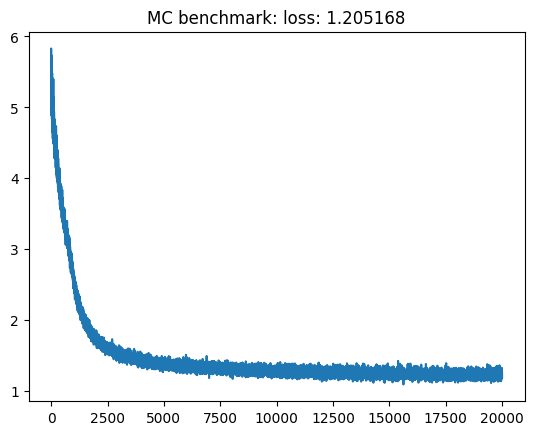

In [312]:
params_mc_benchmark = pd.DataFrame(params_log).T
print(params_mc_benchmark.columns)
col_ = 'loss'
_ = params_mc_benchmark[col_].plot(title='MC benchmark: %s: %.6f'%(col_, params_mc_benchmark[col_].tail(1).values[0]))

In [299]:
print_module(likelihood)
print_module(model)

noise.noise                         (1,)
[1.2648256]
variational_strategy._variational_distribution.variational_mean (15,)
[ 1.3539947   0.15470818  0.59779644 -0.08530366 -1.2822264   0.7443424
  0.31710383 -1.2823901   0.07766872 -0.0547276  -0.00525524 -0.0196104
  0.01006527 -0.06143653  0.88809514]
variational_strategy._variational_distribution.chol_variational_covar (15, 15)
[[ 4.77326989e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.06341504e-01  3.90044242e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.37400970e-01  1.45951360e-01  6.46087229e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(


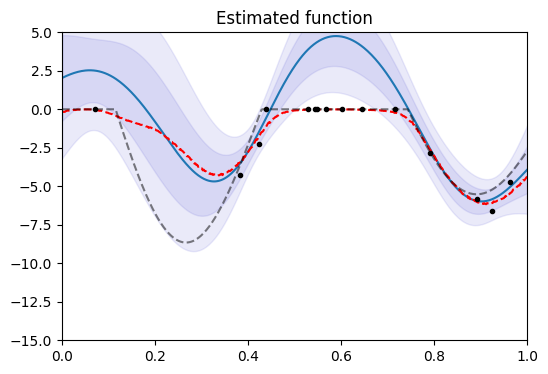

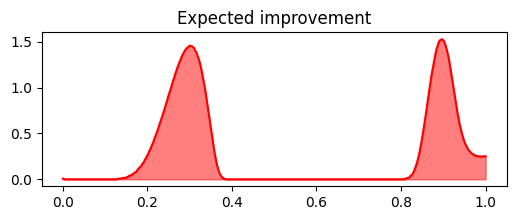

In [300]:
model.eval()
likelihood.eval()

f_preds = model(domain[:,None])
y_preds = likelihood(f_preds)

f_mean = f_preds.loc
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix

N_samples = 1000
breakpoints = torch.linspace(0, 1, N_samples+1)[:-1]
breakpoints = breakpoints + breakpoints[1] * torch.rand_like(breakpoints)

with torch.no_grad():
    pred_samples = torch.distributions.Normal(f_mean, f_var.sqrt()).icdf(breakpoints[:,None])

plot_result(pred_samples)